In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel
from backends.plot             import plot_data, plot_ratio, plot_pull
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

import backends.plot as plot

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
#  Inputs config

cWtil_vals = [0, 0.2]

input_fname_SM_EWK_events  = "../Data/SM_EWK_rivet_output.pickle"
input_fname_EFT_EWK_events = "../Data/cWtil_1p0_linear_500k_rivet_output.dat"

In [3]:
#  Model config

output_size_per_stage     = 30
max_epochs                = 1000
batch_size                = 5000
epoch_increase_per_level  = 200
early_stopping_patience   = 20
early_stopping_min_delta  = 0
validation_split          = 0.5

white_linear_fraction_data  = 1.
white_linear_fraction_gauss = 0.
whitening_num_points        = 400

load_whitening_funcs = None # ".whitening_funcs.pickle"
save_whitening_funcs = ".whitening_funcs.pickle"

load_model_dir = None
save_model_dir = ".EWK_density_model"


In [4]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "m_ll", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order = ["m_jj", "Dy_j_j", "Dphi_j_j"]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables


In [5]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_vals :
    print(f"Creating data table for cWtil={cWtil} from file {input_fname_SM_EWK_events}")
    print(f" -- loading SM events from file {input_fname_SM_EWK_events}")
    data = DataTable(input_fname_SM_EWK_events)
    if cWtil != 0 :
        print(f" -- loading EWK events from file {input_fname_EFT_EWK_events}")
        data_EFT = DataTable(input_fname_EFT_EWK_events)
        data_EFT.scale(cWtil)
        data = data + data_EFT
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0 from file ../Data/SM_EWK_rivet_output.pickle
 -- loading SM events from file ../Data/SM_EWK_rivet_output.pickle
 -- Table created with 200000 events
 -- filtering observable m_ll between 75 and 105
 -- 131786 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 131781 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 131781 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 130081 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 128266 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 128266 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 128266 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 128266 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 128244 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 128159 events survived
 -- filtering obs

 -- 267539 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 267386 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 267386 events survived
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 267386 events survived
 -- filtering observable N_jets between 2 and 5
 -- 267386 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 267386 events survived
 -- removing observable N_jets
 -- removing observable m_ll
 -- removing observable pT_ll
 -- removing observable rap_ll
 -- removing observable theta_ll
 -- removing observable pT_jj
 -- removing observable theta_jj
 -- removing observable rap_jj
 -- removing observable pT_j1
 -- removing observable pT_j2
 -- removing observable N_gap_jets
 -- ordering observables
* Registered the following keys:
    +-------------------------------------+
    | Column | Name     | Type            |
    +-------------------------------------+
    | 0      | m_jj  

In [6]:

whitening_funcs = None
if (type(load_whitening_funcs) != type(None)) :
    print(f"Loading whitening functions from file {load_whitening_funcs}")
    whitening_funcs = pickle.load(open(load_whitening_funcs, "rb"))

axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data, white_linear_fraction_gauss] for key in data.keys]

observable_data, weight_data, white_data_to_fit = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables [cWtil]
    #  Seperate data from weights
    observable_data [cWtil], weight_data [cWtil] = data.get_observables_and_weights()
    #  Whiten data
    print(f"Whitening dataset for cWtil={cWtil}")
    white_data_to_fit[cWtil], whitening_funcs = whiten_axes (observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights())

if type(save_whitening_funcs) != type(None) :
    print(f"Saving whitening functions to file {save_whitening_funcs}")
    pickle.dump(whitening_funcs, open(save_whitening_funcs, "wb"))

weights_to_fit = {k:i/np.sum(i) for k,i in weight_data.items()}


Whitening dataset for cWtil=0
Whitening dataset for cWtil=-0.2
Whitening dataset for cWtil=-0.1
Whitening dataset for cWtil=0.1
Whitening dataset for cWtil=0.2
Saving whitening functions to file .whitening_funcs.pickle


In [7]:
#  Load model if requested, otherwise build and fit
#

if type(load_model_dir) != type(None) :
    density_model = DensityModel.from_dir(load_model_dir)
else :
    #  Create density model
    density_model = DensityModel(name            = "QCD_density_model", 
                                 num_gaussians   = output_size_per_stage, 
                                 num_conditions  = 1, 
                                 num_observables = data.get_num_observables(), 
                                 types           = data.types,
                                 int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                 verbose         = True)
    fit_times = {}
    for obs_idx in range(white_data_to_fit[0.2].shape[1]) :
        fit_start_time = time.time()
        num_epochs = max_epochs + obs_idx*epoch_increase_per_level
        density_model.fit(white_data_to_fit, 
                          weights_to_fit,
                          observable                = obs_idx,
                          max_epochs_per_observable = num_epochs,
                          early_stopping_patience   = early_stopping_patience,
                          early_stopping_min_delta  = early_stopping_min_delta,
                          validation_split          = validation_split,
                          batch_size_per_observable = batch_size)
        fit_times [obs_idx] = [num_epochs, time.time() - fit_start_time]


INFO       DensityModel.construct      Set model name           : QCD_density_model
INFO       DensityModel.construct      Set model num_gaussians  : 20
INFO       DensityModel.construct      Set model num_conditions : 1
INFO       DensityModel.construct      Set model num_observables: 3
INFO       DensityModel.construct      Set observable types     : [<class 'float'>, <class 'float'>, <class 'float'>]
INFO       DensityModel.build          Building model segment: QCD_density_model_observable0 for observable index 0
Creating continuous density model: QCD_density_model_observable0
  - num_conditions_in  is 1
  - num_observables_in is 0
  - num_gaussians      is 20
Instructions for updating:
Colocations handled automatically by placer.
Model: "QCD_density_model_observable0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

Model: "QCD_density_model_observable2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 7)            14          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 6)            18          input_5[0][0]                    
______________________________________________________________________

598851/598851 [==============================] - 3s 4us/step - loss: 4.1252e-06 - val_loss: 4.1166e-06
Epoch 26/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1251e-06 - val_loss: 4.1164e-06
Epoch 27/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1250e-06 - val_loss: 4.1160e-06
Epoch 28/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1247e-06 - val_loss: 4.1159e-06
Epoch 29/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1246e-06 - val_loss: 4.1156e-06
Epoch 30/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1245e-06 - val_loss: 4.1156e-06
Epoch 31/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1244e-06 - val_loss: 4.1155e-06
Epoch 32/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1242e-06 - val_loss: 4.1157e-06
Epoch 33/1000
598851/598851 [==============================] - 3s 4us/step - l

598851/598851 [==============================] - 3s 4us/step - loss: 4.1169e-06 - val_loss: 4.1077e-06
Epoch 96/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1168e-06 - val_loss: 4.1075e-06
Epoch 97/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1168e-06 - val_loss: 4.1076e-06
Epoch 98/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1168e-06 - val_loss: 4.1077e-06
Epoch 99/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1167e-06 - val_loss: 4.1077e-06
Epoch 100/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1167e-06 - val_loss: 4.1074e-06
Epoch 101/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1166e-06 - val_loss: 4.1076e-06
Epoch 102/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1166e-06 - val_loss: 4.1075e-06
Epoch 103/1000
598851/598851 [==============================] - 3s 4us/step

598851/598851 [==============================] - 3s 4us/step - loss: 4.1163e-06 - val_loss: 4.1073e-06
Epoch 165/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1161e-06 - val_loss: 4.1071e-06
Epoch 166/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1161e-06 - val_loss: 4.1073e-06
Epoch 167/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1160e-06 - val_loss: 4.1073e-06
Epoch 168/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1160e-06 - val_loss: 4.1071e-06
Epoch 169/1000
598851/598851 [==============================] - 2s 4us/step - loss: 4.1160e-06 - val_loss: 4.1070e-06
Epoch 170/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1161e-06 - val_loss: 4.1074e-06
Epoch 171/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1160e-06 - val_loss: 4.1071e-06
Epoch 172/1000
598851/598851 [==============================] - 3s 4us/

598851/598851 [==============================] - 3s 4us/step - loss: 4.1157e-06 - val_loss: 4.1069e-06
Epoch 234/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1157e-06 - val_loss: 4.1072e-06
Epoch 235/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1158e-06 - val_loss: 4.1069e-06
Epoch 236/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1157e-06 - val_loss: 4.1071e-06
Epoch 237/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1158e-06 - val_loss: 4.1069e-06
Epoch 238/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1157e-06 - val_loss: 4.1068e-06
Epoch 239/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1067e-06
Epoch 240/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1072e-06
Epoch 241/1000
598851/598851 [==============================] - 2s 4us/

598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1067e-06
Epoch 303/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1069e-06
Epoch 304/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1155e-06 - val_loss: 4.1066e-06
Epoch 305/1000
598851/598851 [==============================] - 2s 4us/step - loss: 4.1155e-06 - val_loss: 4.1066e-06
Epoch 306/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1155e-06 - val_loss: 4.1066e-06
Epoch 307/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1066e-06
Epoch 308/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1067e-06
Epoch 309/1000
598851/598851 [==============================] - 3s 4us/step - loss: 4.1156e-06 - val_loss: 4.1066e-06
Epoch 310/1000
598851/598851 [==============================] - 3s 4us/

Epoch 31/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.4161e-06 - val_loss: 1.4147e-06
Epoch 32/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.4120e-06 - val_loss: 1.4125e-06
Epoch 33/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.4088e-06 - val_loss: 1.4086e-06
Epoch 34/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.4053e-06 - val_loss: 1.4044e-06
Epoch 35/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.4023e-06 - val_loss: 1.4007e-06
Epoch 36/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3987e-06 - val_loss: 1.3994e-06
Epoch 37/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3969e-06 - val_loss: 1.4023e-06
Epoch 38/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3932e-06 - val_loss: 1.3912e-06
Epoch 39/1200
598851/598851 [==============================] - 3

598851/598851 [==============================] - 3s 5us/step - loss: 1.3376e-06 - val_loss: 1.3403e-06
Epoch 102/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3382e-06 - val_loss: 1.3395e-06
Epoch 103/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3381e-06 - val_loss: 1.3395e-06
Epoch 104/1200
598851/598851 [==============================] - 3s 4us/step - loss: 1.3373e-06 - val_loss: 1.3382e-06
Epoch 105/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3374e-06 - val_loss: 1.3380e-06
Epoch 106/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3372e-06 - val_loss: 1.3378e-06
Epoch 107/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3375e-06 - val_loss: 1.3387e-06
Epoch 108/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3367e-06 - val_loss: 1.3415e-06
Epoch 109/1200
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 1.3307e-06 - val_loss: 1.3324e-06
Epoch 171/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3300e-06 - val_loss: 1.3319e-06
Epoch 172/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3300e-06 - val_loss: 1.3322e-06
Epoch 173/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3298e-06 - val_loss: 1.3309e-06
Epoch 174/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3298e-06 - val_loss: 1.3316e-06
Epoch 175/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3295e-06 - val_loss: 1.3328e-06
Epoch 176/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3291e-06 - val_loss: 1.3309e-06
Epoch 177/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3300e-06 - val_loss: 1.3328e-06
Epoch 178/1200
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 1.3152e-06 - val_loss: 1.3190e-06
Epoch 240/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3148e-06 - val_loss: 1.3170e-06
Epoch 241/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3153e-06 - val_loss: 1.3203e-06
Epoch 242/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3145e-06 - val_loss: 1.3177e-06
Epoch 243/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3152e-06 - val_loss: 1.3208e-06
Epoch 244/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3142e-06 - val_loss: 1.3166e-06
Epoch 245/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3143e-06 - val_loss: 1.3164e-06
Epoch 246/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3146e-06 - val_loss: 1.3166e-06
Epoch 247/1200
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 1.3095e-06 - val_loss: 1.3174e-06
Epoch 309/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3092e-06 - val_loss: 1.3111e-06
Epoch 310/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3097e-06 - val_loss: 1.3169e-06
Epoch 311/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3095e-06 - val_loss: 1.3113e-06
Epoch 312/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3088e-06 - val_loss: 1.3137e-06
Epoch 313/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3086e-06 - val_loss: 1.3126e-06
Epoch 314/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3092e-06 - val_loss: 1.3120e-06
Epoch 315/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3092e-06 - val_loss: 1.3112e-06
Epoch 316/1200
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 1.3060e-06 - val_loss: 1.3086e-06
Epoch 378/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3068e-06 - val_loss: 1.3082e-06
Epoch 379/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3068e-06 - val_loss: 1.3100e-06
Epoch 380/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3059e-06 - val_loss: 1.3087e-06
Epoch 381/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3060e-06 - val_loss: 1.3079e-06
Epoch 382/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3063e-06 - val_loss: 1.3090e-06
Epoch 383/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3062e-06 - val_loss: 1.3080e-06
Epoch 384/1200
598851/598851 [==============================] - 3s 5us/step - loss: 1.3056e-06 - val_loss: 1.3085e-06
Epoch 385/1200
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.7997e-06 - val_loss: 6.7798e-06
Epoch 9/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7805e-06 - val_loss: 6.7642e-06
Epoch 10/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7671e-06 - val_loss: 6.7528e-06
Epoch 11/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7572e-06 - val_loss: 6.7454e-06
Epoch 12/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7496e-06 - val_loss: 6.7375e-06
Epoch 13/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7433e-06 - val_loss: 6.7324e-06
Epoch 14/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7382e-06 - val_loss: 6.7275e-06
Epoch 15/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.7337e-06 - val_loss: 6.7231e-06
Epoch 16/1400
598851/598851 [==============================] - 3s 5us/step - lo

598851/598851 [==============================] - 3s 5us/step - loss: 6.6889e-06 - val_loss: 6.6806e-06
Epoch 79/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6885e-06 - val_loss: 6.6801e-06
Epoch 80/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6883e-06 - val_loss: 6.6803e-06
Epoch 81/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6882e-06 - val_loss: 6.6797e-06
Epoch 82/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6883e-06 - val_loss: 6.6797e-06
Epoch 83/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6882e-06 - val_loss: 6.6798e-06
Epoch 84/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6878e-06 - val_loss: 6.6794e-06
Epoch 85/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6875e-06 - val_loss: 6.6798e-06
Epoch 86/1400
598851/598851 [==============================] - 3s 5us/step - l

598851/598851 [==============================] - 3s 5us/step - loss: 6.6806e-06 - val_loss: 6.6719e-06
Epoch 148/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6806e-06 - val_loss: 6.6721e-06
Epoch 149/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6804e-06 - val_loss: 6.6719e-06
Epoch 150/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6806e-06 - val_loss: 6.6728e-06
Epoch 151/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6803e-06 - val_loss: 6.6718e-06
Epoch 152/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6804e-06 - val_loss: 6.6716e-06
Epoch 153/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6800e-06 - val_loss: 6.6722e-06
Epoch 154/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6803e-06 - val_loss: 6.6715e-06
Epoch 155/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6754e-06 - val_loss: 6.6677e-06
Epoch 217/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6753e-06 - val_loss: 6.6676e-06
Epoch 218/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6753e-06 - val_loss: 6.6673e-06
Epoch 219/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6751e-06 - val_loss: 6.6668e-06
Epoch 220/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6749e-06 - val_loss: 6.6673e-06
Epoch 221/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6751e-06 - val_loss: 6.6670e-06
Epoch 222/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6753e-06 - val_loss: 6.6668e-06
Epoch 223/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6749e-06 - val_loss: 6.6666e-06
Epoch 224/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6719e-06 - val_loss: 6.6640e-06
Epoch 286/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6719e-06 - val_loss: 6.6637e-06
Epoch 287/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6717e-06 - val_loss: 6.6642e-06
Epoch 288/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6716e-06 - val_loss: 6.6635e-06
Epoch 289/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6718e-06 - val_loss: 6.6643e-06
Epoch 290/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6717e-06 - val_loss: 6.6638e-06
Epoch 291/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6716e-06 - val_loss: 6.6639e-06
Epoch 292/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6715e-06 - val_loss: 6.6648e-06
Epoch 293/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6700e-06 - val_loss: 6.6617e-06
Epoch 355/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6695e-06 - val_loss: 6.6618e-06
Epoch 356/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6698e-06 - val_loss: 6.6616e-06
Epoch 357/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6698e-06 - val_loss: 6.6617e-06
Epoch 358/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6695e-06 - val_loss: 6.6618e-06
Epoch 359/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6697e-06 - val_loss: 6.6624e-06
Epoch 360/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6695e-06 - val_loss: 6.6620e-06
Epoch 361/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6697e-06 - val_loss: 6.6624e-06
Epoch 362/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6683e-06 - val_loss: 6.6603e-06
Epoch 424/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6682e-06 - val_loss: 6.6616e-06
Epoch 425/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6682e-06 - val_loss: 6.6607e-06
Epoch 426/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6684e-06 - val_loss: 6.6604e-06
Epoch 427/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6683e-06 - val_loss: 6.6614e-06
Epoch 428/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6683e-06 - val_loss: 6.6607e-06
Epoch 429/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6680e-06 - val_loss: 6.6605e-06
Epoch 430/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6681e-06 - val_loss: 6.6603e-06
Epoch 431/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6668e-06 - val_loss: 6.6600e-06
Epoch 493/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6672e-06 - val_loss: 6.6607e-06
Epoch 494/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6669e-06 - val_loss: 6.6591e-06
Epoch 495/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6672e-06 - val_loss: 6.6594e-06
Epoch 496/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6668e-06 - val_loss: 6.6605e-06
Epoch 497/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6669e-06 - val_loss: 6.6595e-06
Epoch 498/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6669e-06 - val_loss: 6.6599e-06
Epoch 499/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6670e-06 - val_loss: 6.6592e-06
Epoch 500/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6656e-06 - val_loss: 6.6583e-06
Epoch 562/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6657e-06 - val_loss: 6.6581e-06
Epoch 563/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6656e-06 - val_loss: 6.6599e-06
Epoch 564/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6660e-06 - val_loss: 6.6584e-06
Epoch 565/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6657e-06 - val_loss: 6.6578e-06
Epoch 566/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6658e-06 - val_loss: 6.6581e-06
Epoch 567/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6656e-06 - val_loss: 6.6578e-06
Epoch 568/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6658e-06 - val_loss: 6.6582e-06
Epoch 569/1400
598851/598851 [==============================] - 3s 5us/

598851/598851 [==============================] - 3s 5us/step - loss: 6.6646e-06 - val_loss: 6.6576e-06
Epoch 631/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6647e-06 - val_loss: 6.6569e-06
Epoch 632/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6647e-06 - val_loss: 6.6572e-06
Epoch 633/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6648e-06 - val_loss: 6.6570e-06
Epoch 634/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6646e-06 - val_loss: 6.6569e-06
Epoch 635/1400
598851/598851 [==============================] - 3s 5us/step - loss: 6.6645e-06 - val_loss: 6.6575e-06
Fit completed in 1846s


In [8]:
#  Use this cell to add training epochs to whichever indices appear undertrained

improve_indices   = [0, 1, 2]
impove_batch_size = -1
impove_num_epochs = 1000
improve_patience  = 10
improve_validation_split = 0.5

added_fit_times = {}
for obs_idx in improve_indices :
    fit_start_time = time.time()
    density_model.fit(white_data_to_fit, 
                      weights_to_fit,
                      observable                = obs_idx,
                      max_epochs_per_observable = impove_num_epochs,
                      early_stopping_patience   = improve_patience,
                      validation_split          = improve_validation_split,
                      batch_size_per_observable = impove_batch_size)
    added_fit_times [obs_idx] = [impove_num_epochs, time.time() - fit_start_time]
    

INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = -1
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
INFO       DensityModel.fit            Setting batch size to size of dataset, which is 1197703
Train on 598851 samples, validate on 598852 samples
Epoch 1/1000
598851/598851 [==============================] - 5s 9us/step - loss: 4.1069e-06 - val_loss: 4.1151e-06
Epoch 2/1000
598851/598851 [==============================] - 3s 5us/step - loss: 4.1069e-06 - va

Epoch 7/1000
598851/598851 [==============================] - 3s 5us/step - loss: 6.6527e-06 - val_loss: 6.6687e-06
Epoch 8/1000
598851/598851 [==============================] - 3s 5us/step - loss: 6.6527e-06 - val_loss: 6.6687e-06
Epoch 9/1000
598851/598851 [==============================] - 3s 5us/step - loss: 6.6527e-06 - val_loss: 6.6687e-06
Epoch 10/1000
598851/598851 [==============================] - 3s 5us/step - loss: 6.6527e-06 - val_loss: 6.6687e-06
Epoch 11/1000
598851/598851 [==============================] - 3s 5us/step - loss: 6.6526e-06 - val_loss: 6.6687e-06
Fit completed in 34s


In [9]:
#  Save model if requested

if type(save_model_dir) != type(None) :
    density_model.save_to_dir(save_model_dir)

In [10]:
#  Generate a large number of datapoints
#
fake_white_datapoints = {}
for cWtil in cWtil_vals :
    n_gen = 500000 # len(observable_data[cWtil])
    print(f"Generating {n_gen} fake datapoints for cWtil={cWtil}")
    start = time.time()
    fake_white_datapoints[cWtil] = density_model.sample(n_gen, [cWtil])
    end = time.time()
    print(f"{n_gen} datapoints generated in {int(end-start):.0f}s")

#  Unwhiten generated data
#
print("Unwhitening the generated datapoints")
fake_datapoints = {}
for cWtil in cWtil_vals :
    print(f"Unwhitening generated datapoints for cWtil={cWtil}")
    fake_datapoints [cWtil] = unwhiten_axes(fake_white_datapoints[cWtil], whitening_funcs)


Generating 500000 fake datapoints for cWtil=0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
500000 datapoints generated in 186s
Generating 500000 fake datapoints for cWtil=-0.2
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 2
500000 datapoints generated in 183s
Generating 500000 fake datapoints for cWtil=-0.1
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 500000 datapoints, observable index is 1
INFO       DensityModel.sample         Sampling 500000 datapoints, obser

Filter efficiency is 100.000%


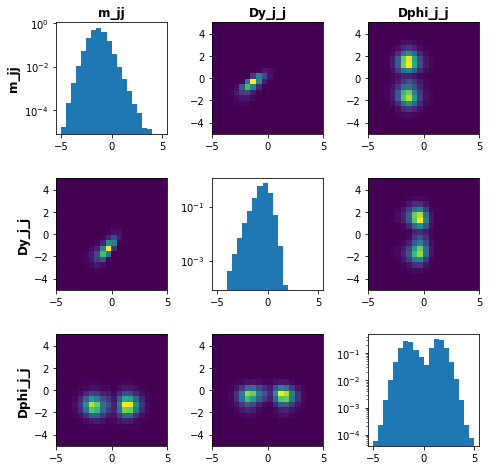

Filter efficiency is 100.000%


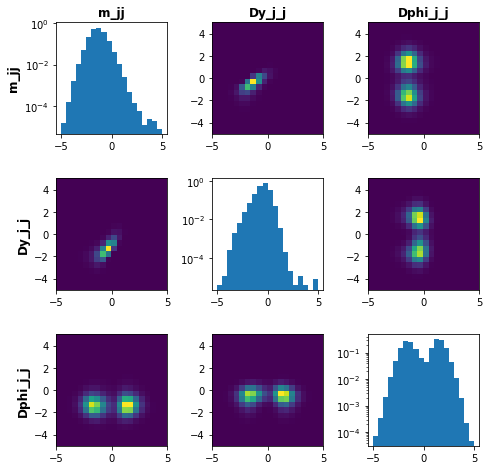

Filter efficiency is 100.000%


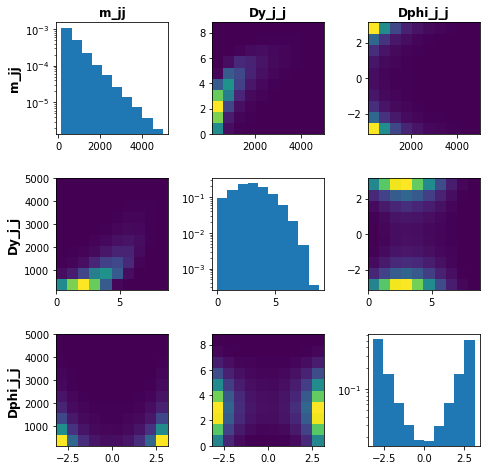

Filter efficiency is 100.000%


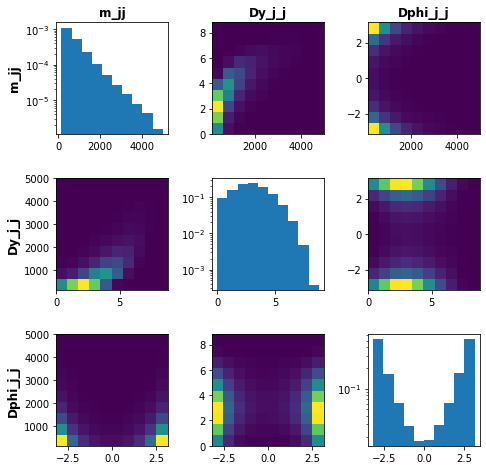

Filter efficiency is 100.000%


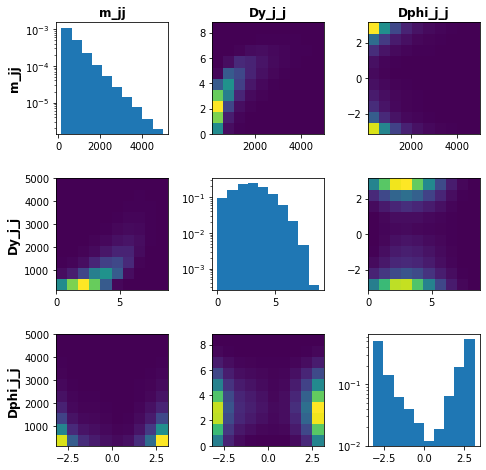

Filter efficiency is 100.000%


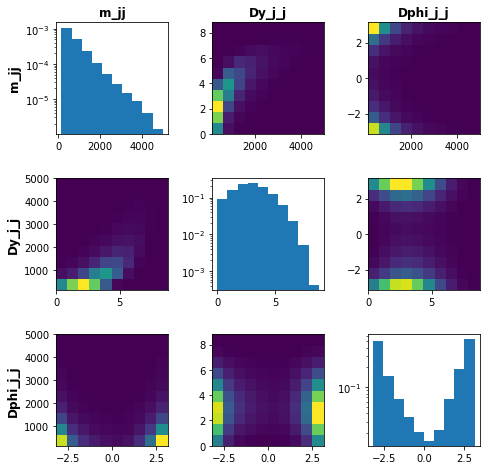

In [11]:
#  Plot original and generate data (total phase space)

plot_data(white_data_to_fit[0.2], weights_to_fit[0.2], keys=data.keys, bins=20, lims=False)
plot_data(fake_white_datapoints[0.2], None, keys=data.keys, bins=20, lims=False)

plot_data(observable_data[0], weights_to_fit[0], keys=data.keys, bins=10)
plot_data(fake_datapoints[0], keys=data.keys, bins=10)

plot_data(observable_data[0.2], weights_to_fit[0.2], keys=data.keys, bins=10)
plot_data(fake_datapoints[0.2], keys=data.keys, bins=10)

In [12]:
#  Plot data (VBF fiducial)

cuts = []
cuts.append(["m_jj"  , 1000, 5000])
cuts.append(["Dy_j_j", 2   , 8.8 ])

#plot_data(observable_data[0.2], weight_data[0.2], cuts=cuts, keys=data.keys, bins=10)
#plot_data(fake_datapoints[0.2], cuts=cuts, keys=data.keys, bins=10)


Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value enco

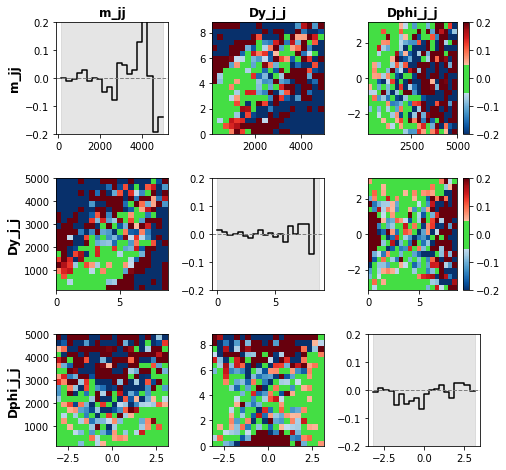

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den


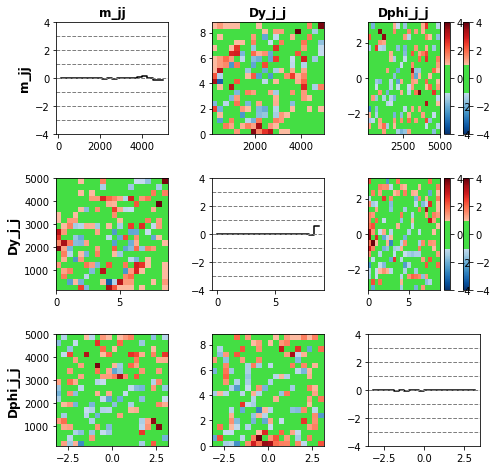

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: divide by zero encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ1 = EZ1 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:166: RuntimeWarning: invalid value encountered in true_divide
  frac_EZ2 = EZ2 / Z2
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: divide by zero encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:167: RuntimeWarning: invalid value encountered in true_divide
  ratio     = Z2 / Z1
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:165: RuntimeWarning: invalid value enc

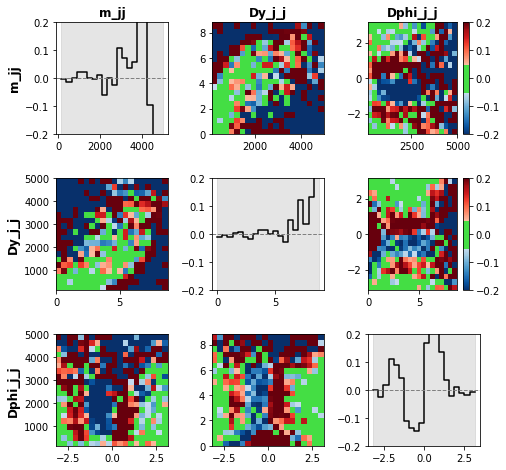

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den
/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation/backends/plot.py:179: RuntimeWarning: invalid value encountered in true_divide
  return X, Y, num/den


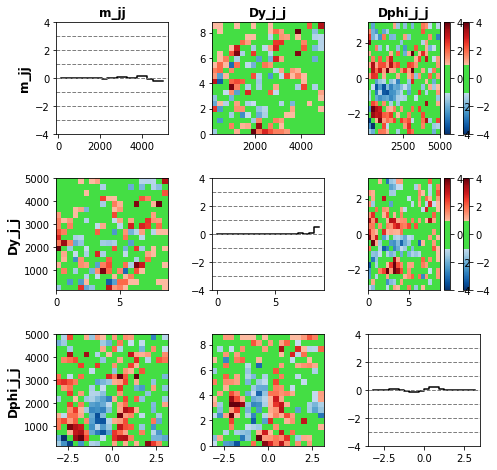

In [13]:
#  Plot ratio and pull between original and generated data (total phase space)

plot_ratio(observable_data[0], fake_datapoints[0], weights_to_fit[0], None, keys=data.keys, bins=20)
plot_pull(observable_data[0], fake_datapoints[0], weights_to_fit[0], None, keys=data.keys, bins=20)

plot_ratio(observable_data[0.2], fake_datapoints[0.2], weights_to_fit[0.2], None, keys=data.keys, bins=20)
plot_pull(observable_data[0.2], fake_datapoints[0.2], weights_to_fit[0.2], None, keys=data.keys, bins=20)


In [14]:
#  Plot ratio between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0], fake_datapoints[0], weight_data[0], None, keys=data.keys, bins=10, cuts=cuts)

#  Plot pull between original and generated data (VBF fiducial)

#plot_ratio(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)
#plot_pull(observable_data[0.2], fake_datapoints[0.2], weight_data[0.2], None, keys=data.keys, bins=10, cuts=cuts)


In [15]:
from matplotlib import pyplot as plt
from backends.plot import get_ratio_1D

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable (observable, data_num, data_den, weights_num=None, weights_den=None, keys=None, cuts=[], save="", lims=True, bins=20) :
    if type(weights_num) == type(None) :
        weights_num = np.ones(shape=(data_num.shape[0],))
    if type(keys) == type(None) :
        keys = [f"obs{i}" for i in range(len(data_num))]
    filtered_data_num, filtered_weights_num = data_num, weights_num
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for numerator")
        filtered_data_num, filtered_weights_num = filter_data (filtered_data_num, filtered_weights_num, keys, cut[0], cut[1], cut[2])
    print(f"Numerator filter efficiency is {100.*np.sum(filtered_weights_num)/np.sum(weights_num):.3f}%")
    
    if type(weights_den) == type(None) :
        weights_den = np.ones(shape=(data_den.shape[0],))
    filtered_data_den, filtered_weights_den = data_den, weights_den
    for cut in cuts :
        print(f"Filtering {cut[0]} between {cut[1]} and {cut[2]} for denominator")
        filtered_data_den, filtered_weights_den = filter_data (filtered_data_den, filtered_weights_den, keys, cut[0], cut[1], cut[2])
    print(f"Denominator filter efficiency is {100.*np.sum(filtered_weights_den)/np.sum(weights_den):.3f}%")
    
    obs_idx = keys.index(observable)
    
    if lims : 
        obs_lims = observable_limits[observable]
    else :
        obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(observable, weight="bold", fontsize=12)    
    data_x, data_z, data_ez = get_ratio_1D(filtered_data_den[:,obs_idx], filtered_data_num[:,obs_idx], bins, filtered_weights_den, filtered_weights_num, as_lines=True)
    data_z = np.nan_to_num(data_z)
    ax.plot(data_x, data_z-1., color="k")
    ax.fill_between(data_x, data_z+data_ez-1, data_z-data_ez-1, alpha=0.2, color="grey")
    ax.axhline(0 , linestyle="-", c="grey", linewidth=2)
    ax.axhline(0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.1 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.2 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.3 , linestyle="--", c="grey", linewidth=0.5)
    ax.axhline(-0.4 , linestyle="--", c="grey", linewidth=0.5)
    ax.set_ylim([-0.9, 0.9])
    
    plt.show()

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


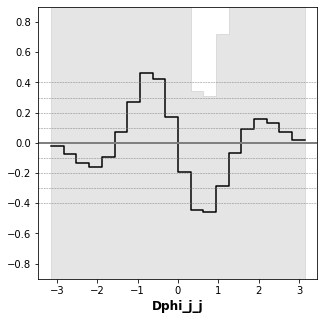

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


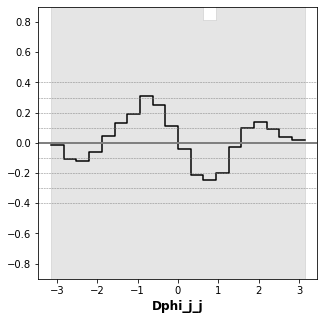

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


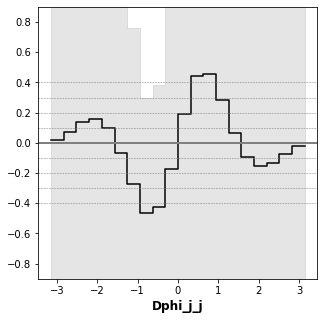

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


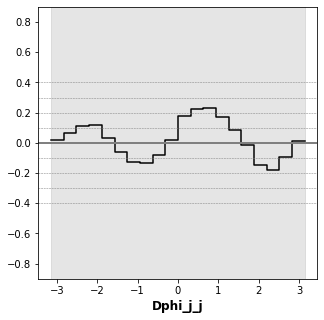

In [16]:

plot_observable("Dphi_j_j", observable_data[0.2], observable_data[0], weights_to_fit[0.2], weights_to_fit[0], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0.2], fake_datapoints[0], None, None, keys=data.keys, bins=20)

plot_observable("Dphi_j_j", observable_data[-0.2], observable_data[0], weights_to_fit[-0.2], weights_to_fit[0], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], fake_datapoints[0], None, None, keys=data.keys, bins=20)


Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 24.992%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 24.991%


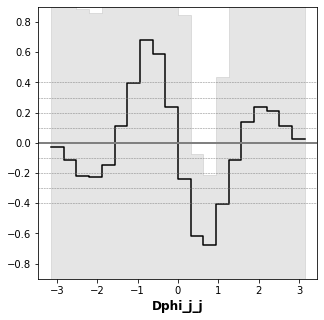

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.294%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.174%


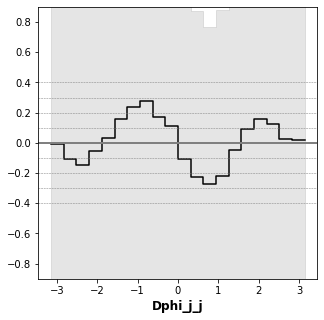

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 24.991%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 24.991%


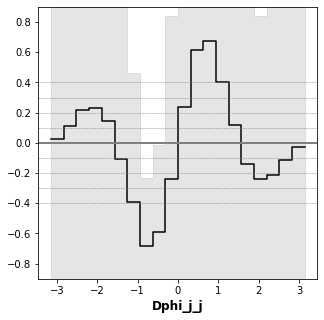

Filtering m_jj between 1000 and 5000 for numerator
Filtering Dy_j_j between 2 and 8.8 for numerator
Numerator filter efficiency is 25.028%
Filtering m_jj between 1000 and 5000 for denominator
Filtering Dy_j_j between 2 and 8.8 for denominator
Denominator filter efficiency is 25.174%


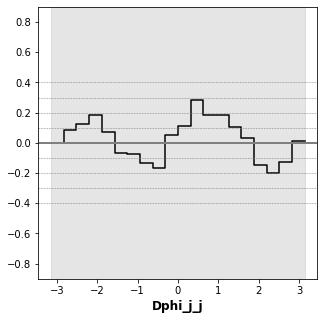

In [17]:

plot_observable("Dphi_j_j", observable_data[0.2], observable_data[0], weight_data[0.2], weight_data[0], keys=data.keys, cuts=cuts, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0.2], fake_datapoints[0], None, None, keys=data.keys, cuts=cuts, bins=20)



plot_observable("Dphi_j_j", observable_data[-0.2], observable_data[0], weight_data[-0.2], weight_data[0], keys=data.keys, cuts=cuts, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], fake_datapoints[0], None, None, keys=data.keys, cuts=cuts, bins=20)




Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


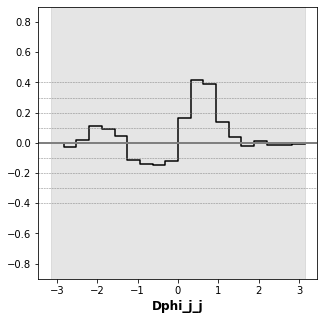

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


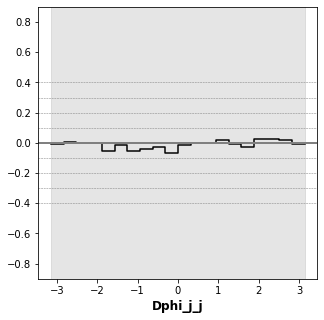

Numerator filter efficiency is 100.000%
Denominator filter efficiency is 100.000%


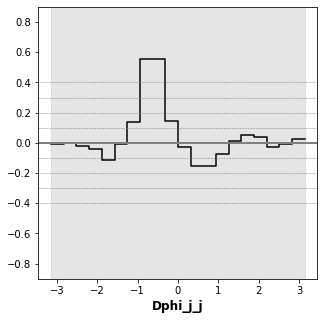

In [18]:

plot_observable("Dphi_j_j", fake_datapoints[0.2], observable_data[0.2], None, weight_data[0.2], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[0], observable_data[0], None, weight_data[0], keys=data.keys, bins=20)
plot_observable("Dphi_j_j", fake_datapoints[-0.2], observable_data[-0.2], None, weight_data[-0.2], keys=data.keys, bins=20)


In [19]:
#  Plot the datapoints provided
#
def get_eff (data, weights=None, keys=[], cuts=[]) :
    if type(weights) == type(None) :
        weights = np.ones(shape=(data.shape[0],))
    filtered_data, filtered_weights = data, weights
    for cut in cuts :
        filtered_data, filtered_weights = filter_data (filtered_data, filtered_weights, keys, cut[0], cut[1], cut[2])
    return 100.*np.sum(filtered_weights)/np.sum(weights)


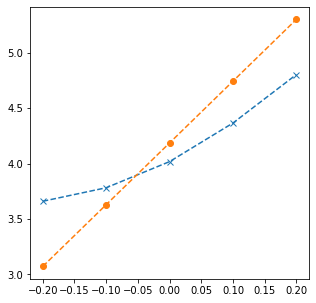

In [20]:
x, y1, y2 = [], [], []
for cWtil in sorted(cWtil_vals) :
    e1 = get_eff(fake_datapoints[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    e2 = get_eff(observable_data[cWtil], weights_to_fit[cWtil], keys=data.keys, cuts=[["Dphi_j_j", -1.5, 0]])
    x.append(cWtil)
    y1.append(e1)
    y2.append(e2)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y1, "x--")
ax.plot(x, y2, "o--")
plt.show()